# [캡스톤 06] 로지스틱ㅣ🍎 사과 품질 분류

## 준비작업

### 패키지 참조

In [1]:
# 라이브러리 기본 참조
from pandas import DataFrame, Series, concat
from matplotlib import pyplot as plt
from hossam import *

📦 아이티윌 이광호 강사가 제작한 라이브러리를 사용중입니다.
📚 자세한 사용 방법은 https://py.hossam.kr 을 참고하세요.
📧 Email: leekh4232@gmail.com
🎬 Youtube: https://www.youtube.com/@hossam-codingclub
📝 Blog: https://blog.hossam.kr/
🔖 Version: 0.3.9

✅ 시각화를 위한 한글 글꼴(NotoSansKR-Regular)이 자동 적용되었습니다.


### 데이터 불러오기

In [2]:
origin = hs_util.load_data("apple_quality")

[data] https://data.hossam.kr/data/kaggle/apple_quality.xlsx
[desc] 이 데이터 세트는 다양한 과일 속성에 대한 정보를 담고 있어 과일의 특성을 파악하는 데 도움이 됩니다. 데이터 세트에는 과일 ID, 크기, 무게, 당도, 아삭함, 과즙량, 숙성도, 산도 및 품질과 같은 세부 정보가 포함되어 있습니다. (출처: https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality)

[!] Cannot read metadata

✅ 테이블 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 281.4+ KB


✅ 상위 5개 행
+---+------+--------------+--------------+----------

## 1단계. 데이터와 첫인상 - “이 데이터는 어떤 세계를 보여주고 있을까?”

1. 데이터의 전체 구조를 확인하자.
   - 관측치 수
   - 변수 타입 (연속형 / 범주형)
2. 아직 분석을 하지 않은 상태에서 중요해 보이는 변수를 직관적으로 예측해 보자.

> 📌 **출제 의도**
> 이 단계는 데이터를 바로 분석 대상으로 보기보다,
> **현실의 대상(사과)을 설명하는 정보로 이해하는 연습**을 하기 위한 단계이다.
> 변수 이름을 해석하지 못하면 이후 분석도 설득력을 갖기 어렵다.

### 1-1. 종속변수 라벨링

In [3]:
df = hs_prep.labelling(origin, "Quality")
display(df.head())

Quality      label
---------  -------
bad              0
good             1


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1


### 1-2. 결측치 확인

In [4]:
df.isna().sum()

A_id           0
Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

### 1-3. 기술통계량

In [5]:
df.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877,0.501000
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270,0.500062
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538,0.000000
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424,0.000000
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609,1.000000
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493,1.000000
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736,1.000000


#### 💡 인사이트

- 관측치 4,000개, 변수 9개(연속형 7 + 식별자 1 + 목표변수 1)로 구성되어 있음.
- 범주형은 `Quality` 하나뿐이며 `A_id`는 식별자라 예측 변수에서 제외할 예정.
- 상식 범주의 도메인 지식에 근거하여 사과의 크기(`Size`), 당도(`Sweetness`), 과즙(`Juiciness`), 익은 정도(`Ripeness`)가 직관적으로 품질에 직접 연결될 가능성이 높아 보임.

## 2단계. 목표 변수 시각화 - “우리가 맞히려는 대상은 어떤 분포를 가지고 있을까?”

1. `Quality`의 분포를 막대그래프로 시각화하자.
2. 좋은 사과와 그렇지 않은 사과의 비율을 확인하자.
3. 이 분포를 보고 정확도 하나만으로 모델을 평가해도 괜찮을지 고민해 보자.

> 📌 **출제 의도**
> 분류 문제에서는 모델보다 먼저
> **무엇을 얼마나 자주 맞혀야 하는지**를 이해하는 것이 중요하다.
> 이 단계는 성능 지표를 선택하는 이유를 스스로 고민하게 하기 위함이다.

  Quality    count    ratio
---------  -------  -------
        0     1996    0.499
        1     2004    0.501


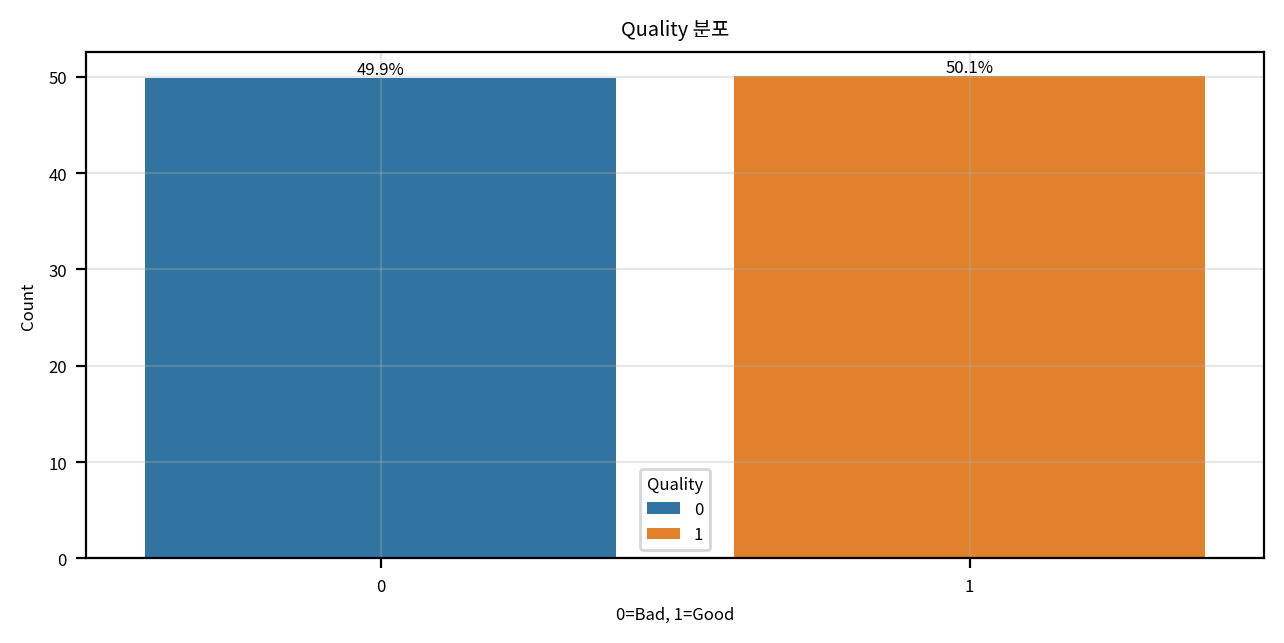

In [6]:
def count_plot(ax) -> None:
    quality_counts = df["Quality"].value_counts().sort_index()
    quality_ratio = quality_counts / len(df)
    ratio_df = concat(
        [quality_counts.rename("count"), quality_ratio.rename("ratio")], axis=1
    )

    hs_util.pretty_table(ratio_df)

    for i in ratio_df.index:
        r = ratio_df.iloc[i]["ratio"] * 100
        ax.text(i, r, f"{r}%", ha="center", va="bottom")

    ax.set_title("Quality 분포")
    ax.set_ylabel("Count")
    ax.set_xlabel("0=Bad, 1=Good")


hs_plot.countplot(
    df=df,
    xname="Quality",
    hue="Quality",
    stat="percent",
    callback=count_plot,
)

#### 💡 인사이트

- `good` 50.1%, `bad` 49.9%로 거의 균형 잡힌 분포.
- 정확도만 써도 왜곡은 적지만 오분류 비용을 고려해 정밀도·재현율·AUC까지 함께 확인하는 것이 안전하다.

## 3단계. 단변량 EDA - “사과 하나만 놓고 보았을 때, 무엇이 보일까?”

각 연속형 변수에 대해 다음을 수행하자.

1. 히스토그램과 KDE를 그려 분포를 확인하자.
2. 왜도(skewness)가 있는 변수를 찾아보자.
3. 눈에 띄는 이상치가 있는지 시각적으로 판단하자.

> 📌 **출제 의도**
> 이 단계는 모델 성능을 높이기 위한 작업이 아니라, **데이터가 가진 기본적인 성질을 이해하는 과정**이다.
> 분포의 모양을 설명할 수 있다면 충분하다.

### 3-1. 데이터 분포 확인

In [7]:
feature_cols = [
    "Size",
    "Weight",
    "Sweetness",
    "Crunchiness",
    "Juiciness",
    "Ripeness",
    "Acidity",
]

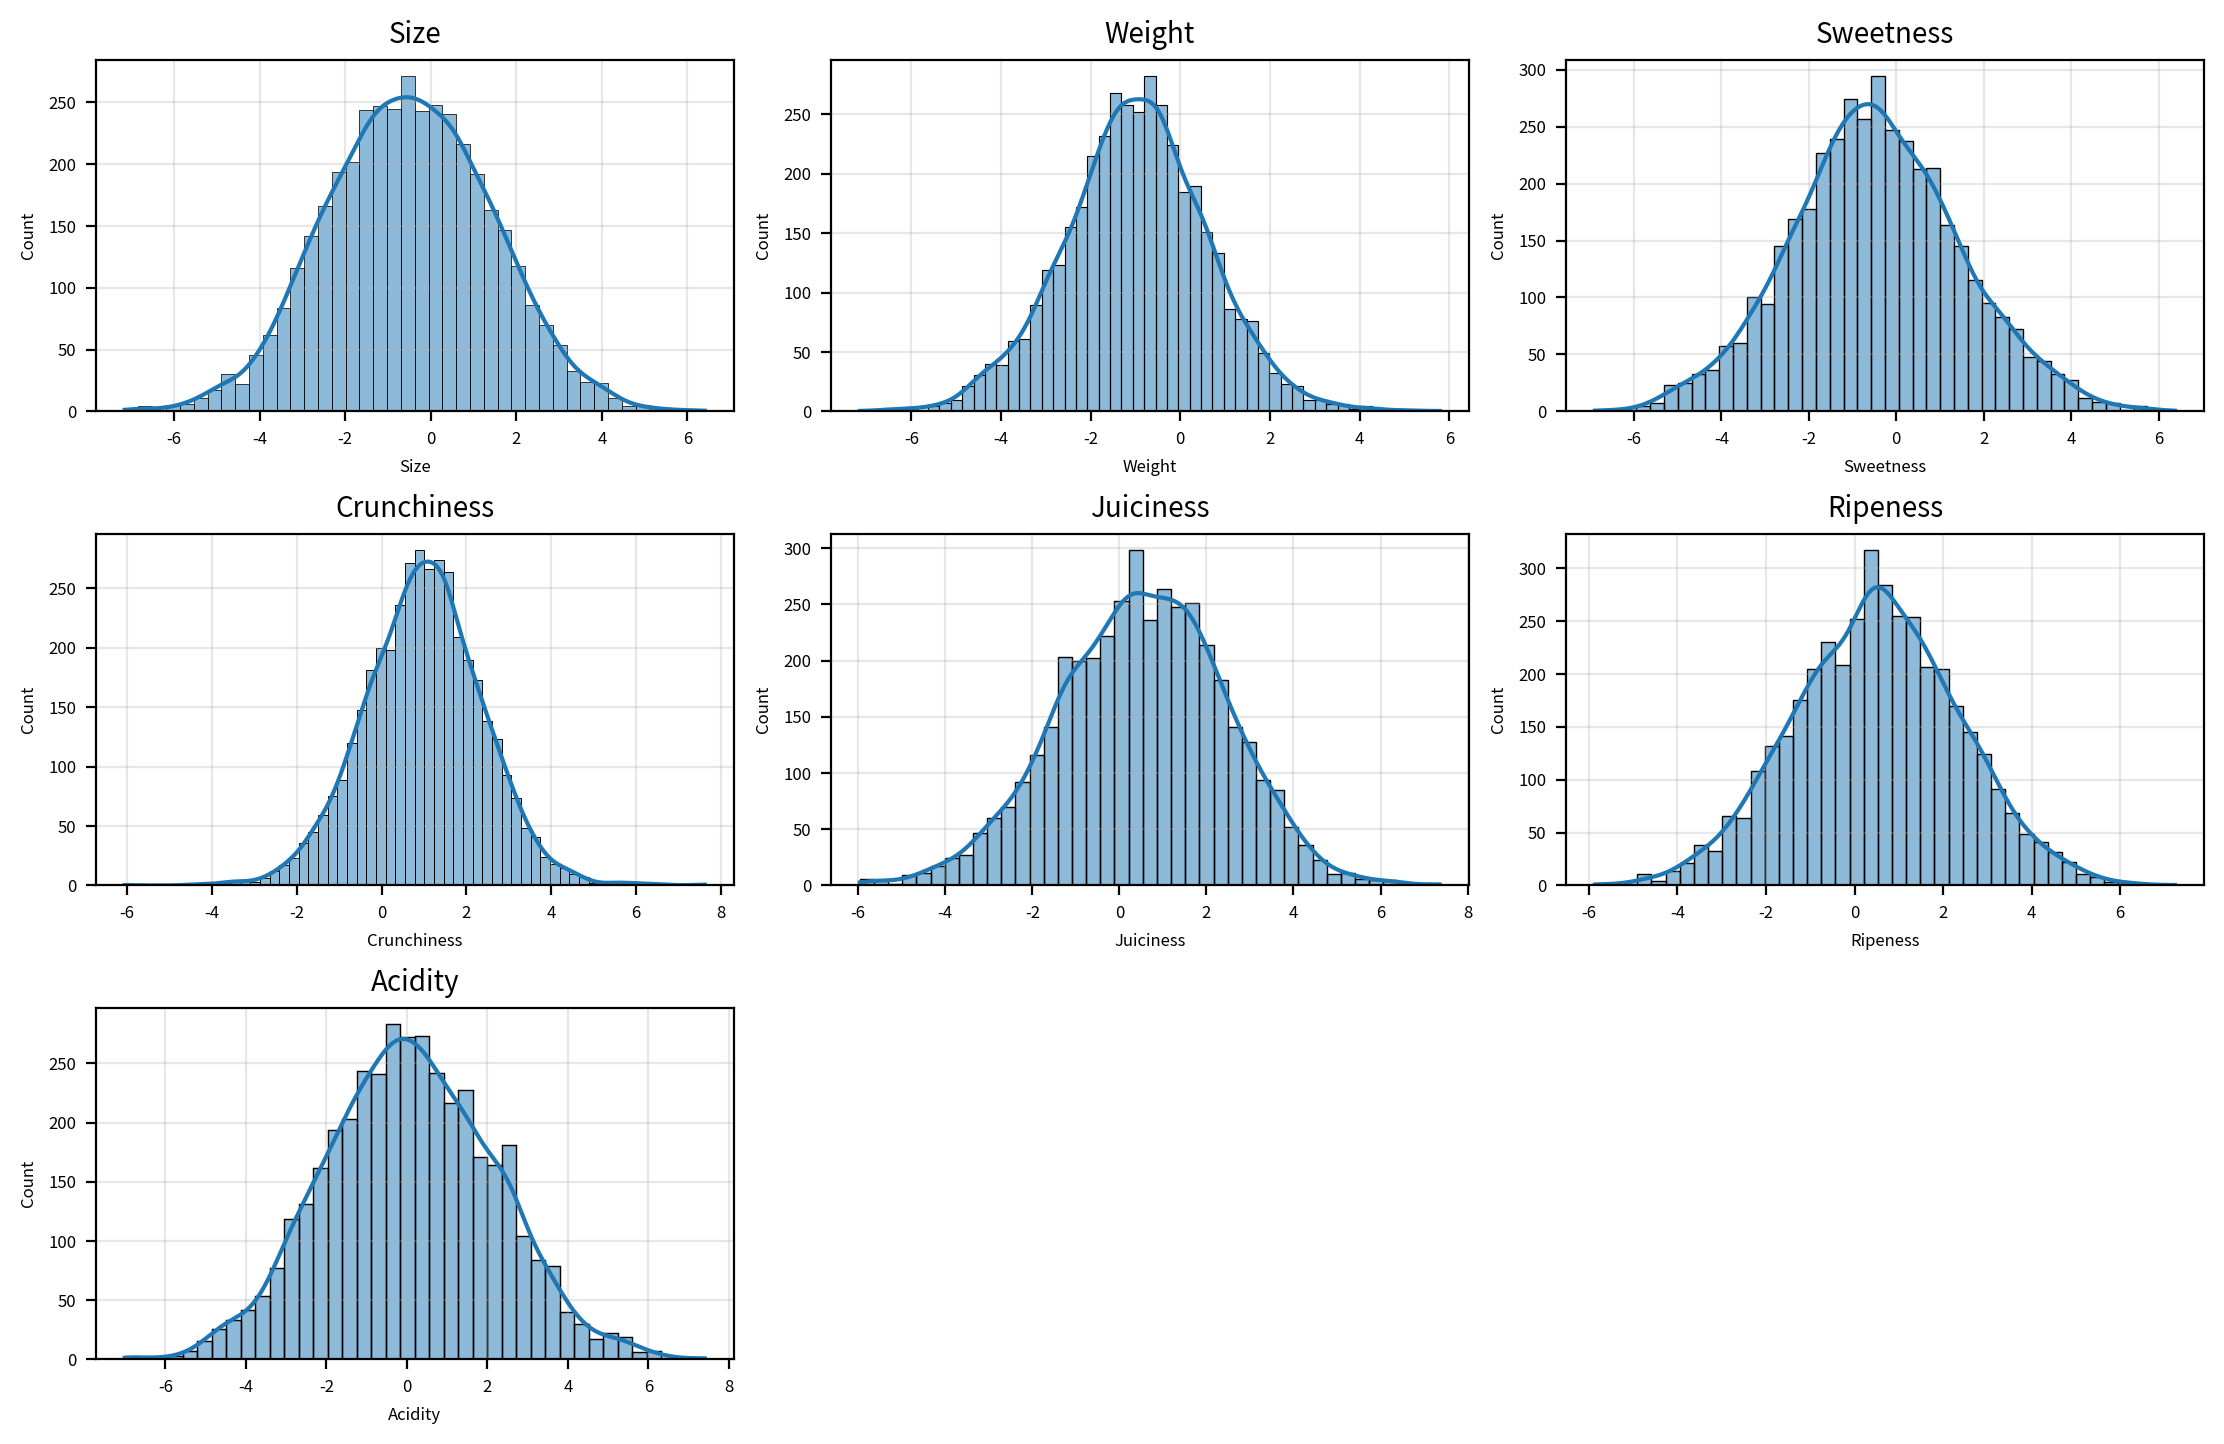

In [8]:
fig, ax = hs_plot.get_default_ax(
    width=740, height=480, rows=3, cols=3, flatten=True, ws=1, hs=1
)

i = 0
for f in feature_cols:
    hs_plot.histplot(
        df=df,
        xname=f,
        kde=True,
        ax=ax[i],
        callback=lambda ax: ax.set_title(f, fontsize=10),
    )
    i += 1

for a in range(i, len(ax)):
    ax[a].axis("off")

hs_plot.finalize_plot(ax)

### 3-2. 이상치 및 왜도 확인

In [9]:
hs_stats.outlier_table(df.drop("Quality", axis=1))

,q1,q2,q3,iqr,up,down,skew
field,,,,,,,
A_id,999.750000,1999.500000,2999.250000,1999.500000,5998.500000,-1999.500000,0.000000
Size,-1.816765,-0.513703,0.805526,2.622291,4.738963,-5.750201,-0.002437
Weight,-2.011770,-0.984736,0.030976,2.042747,3.095097,-5.075890,0.003102
Sweetness,-1.738425,-0.504758,0.801922,2.540347,4.612442,-5.548946,0.083850
Crunchiness,0.062764,0.998249,1.894234,1.831470,4.641439,-2.684440,0.000230
Juiciness,-0.801286,0.534219,1.835976,2.637262,5.791870,-4.757179,-0.113421
Ripeness,-0.771677,0.503445,1.766212,2.537889,5.573044,-4.578510,-0.008764
Acidity,-1.377424,0.022609,1.510493,2.887917,5.842368,-5.709299,0.055783


#### 💡 인사이트

- 모든 연속형 변수의 왜도 절댓값이 0.1 이내로 대체로 대칭적이며 분포가 완만하다.
- IQR 기준 이상치는 `Weight`와 `Crunchiness`에서 상대적으로 많지만(50개 안팎) 전체 비중은 크지 않다.
- 극단치가 있으나 분포 왜곡이 심하지 않아 우선은 그대로 사용하고, 모델 적합 후 영향이 크면 추가로 조정할 수 있다.

## 4단계. 이변량 EDA - “품질에 따라 무엇이 달라질까?”

1. `Quality`를 기준으로 각 연속형 변수의 분포를 boxplot로 비교하자.
2. 중앙값 차이가 분명한 변수와 분포가 크게 겹치는 변수를 구분하자.
3. 분류에 도움이 될 것 같은 변수를 골라 보자.

> 📌 **출제 의도**
> 이 단계는 통계 검정 이전에
> **그래프를 근거로 판단하는 연습**을 하기 위한 단계이다.
> “그래서 이 변수가 중요해 보인다”라는 설명이 나오면 충분하다.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test independent samples, P_val:2.628e-55 t=-1.591e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test independent samples, P_val:9.284e-01 t=-8.985e-02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test independent samples, P_val:1.610e-58 t=-1.640e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: t-test independent sample

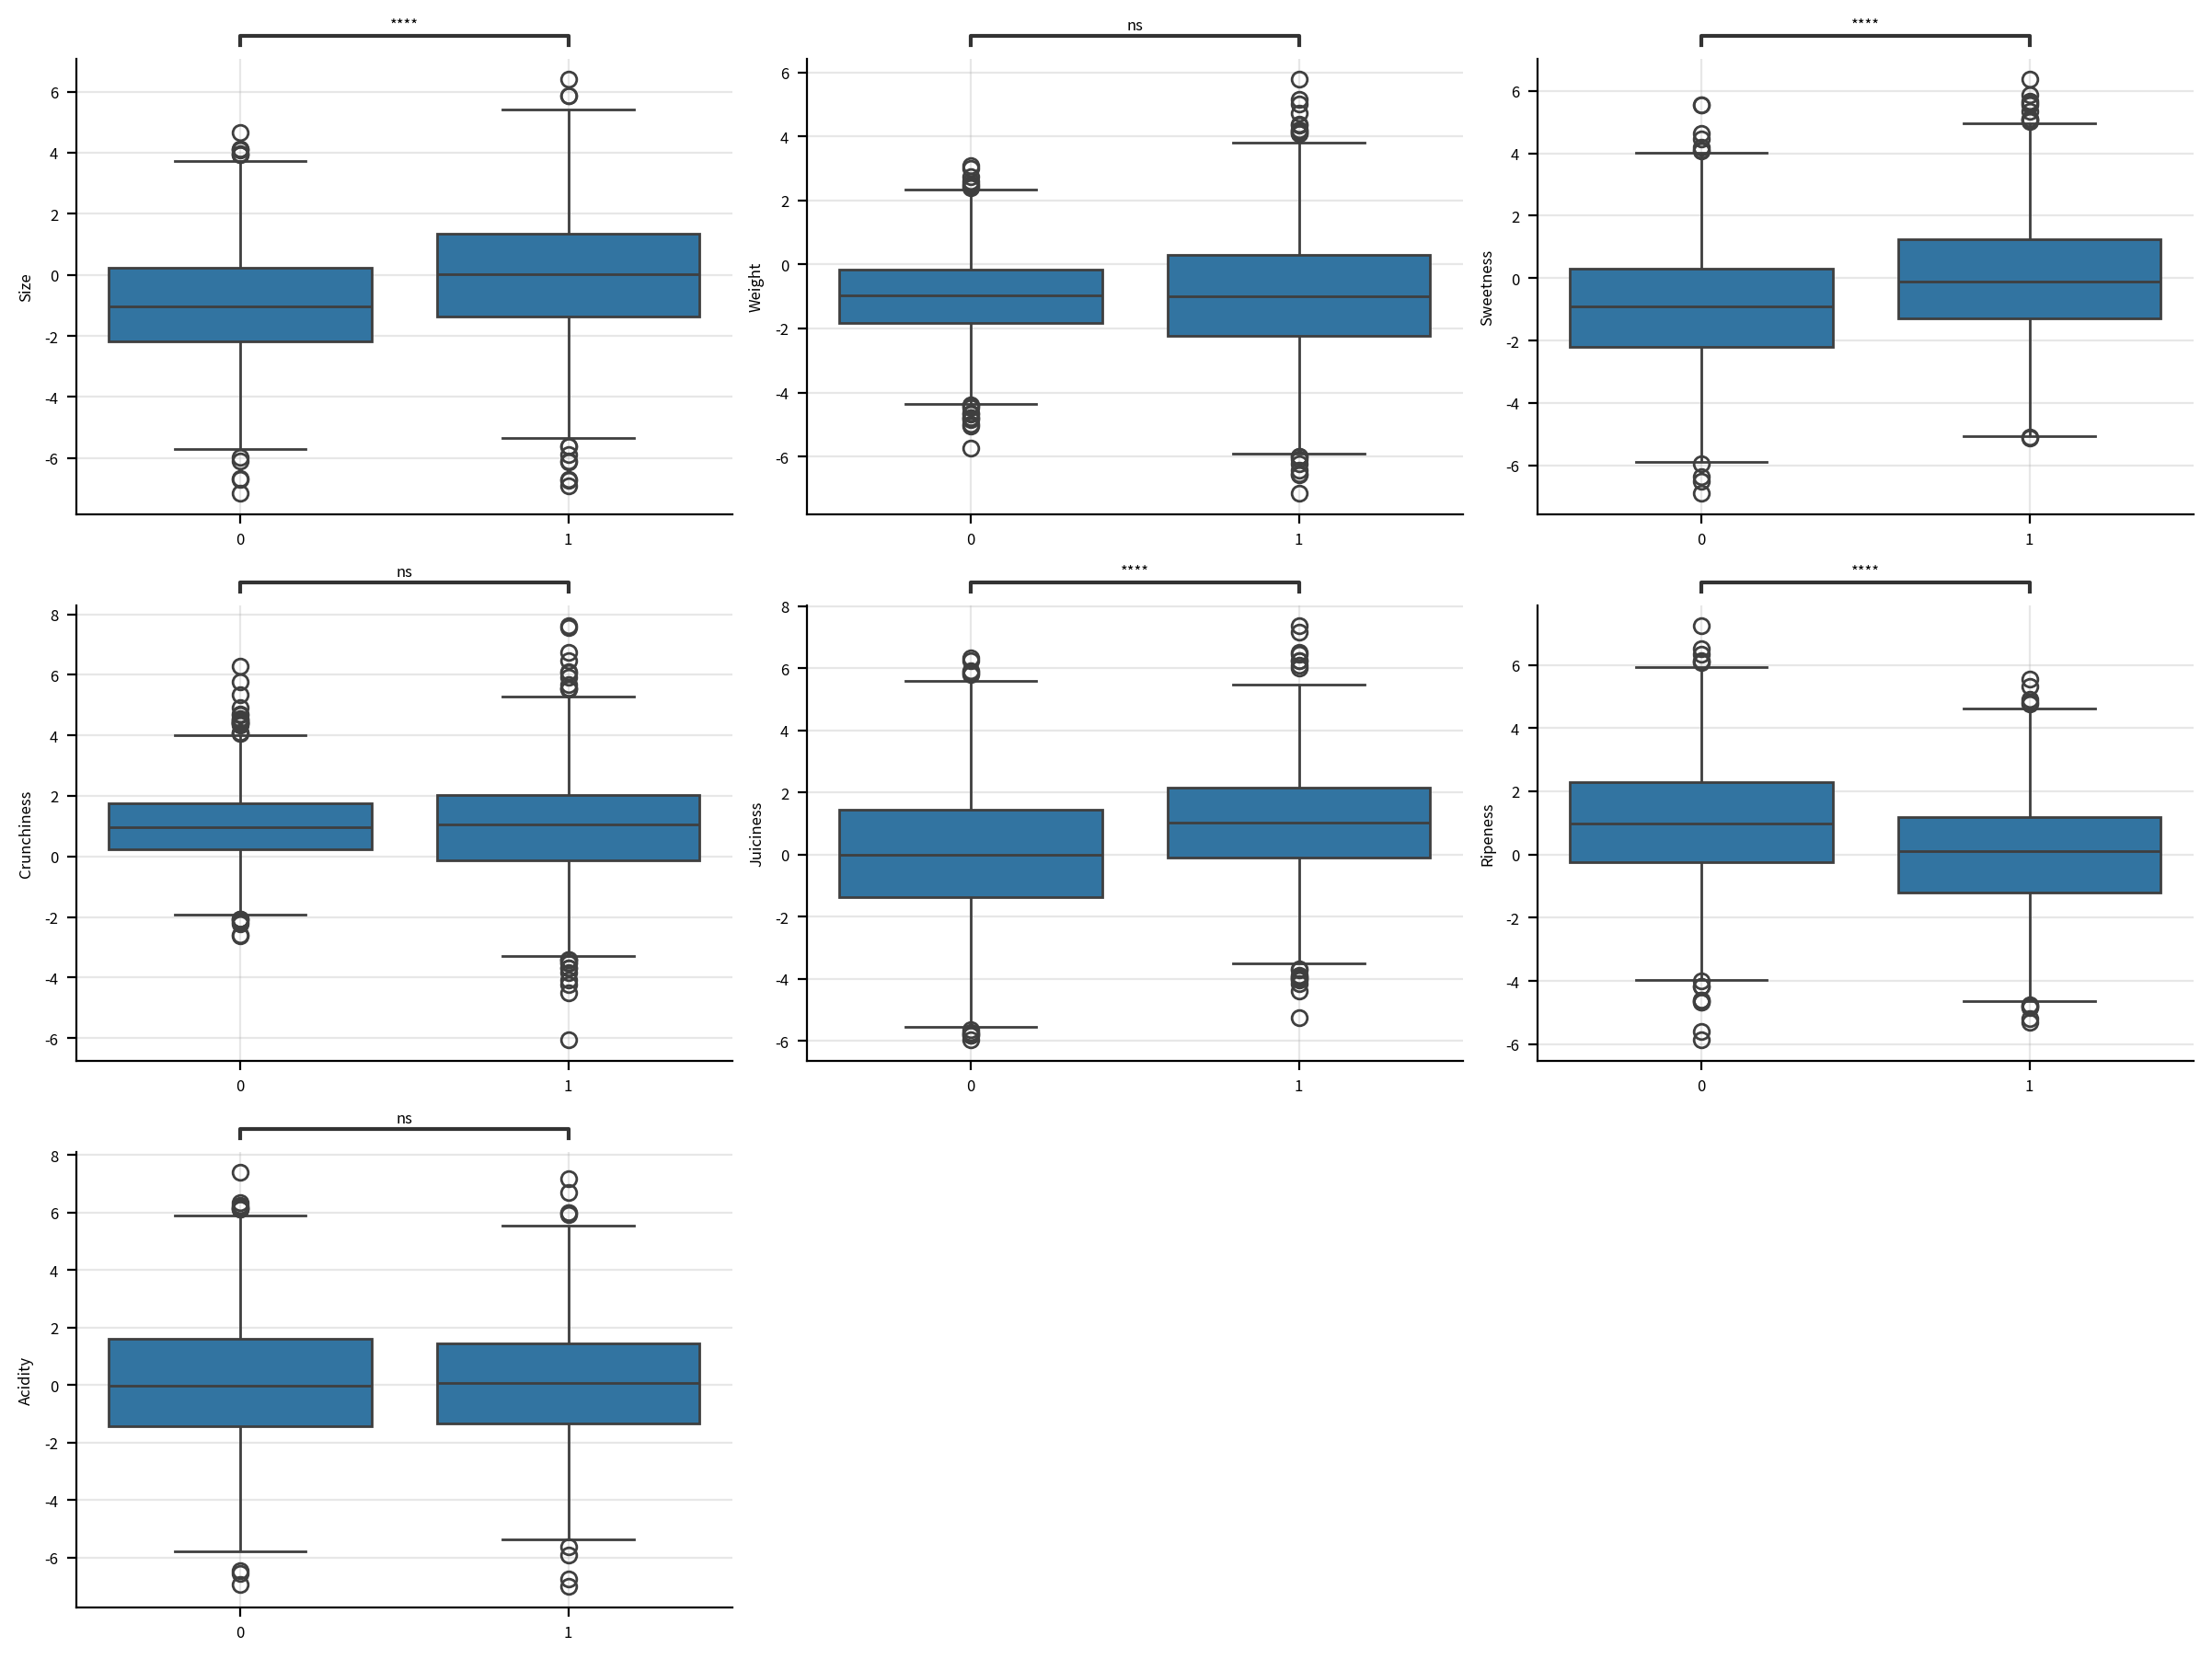

In [10]:
fig, ax = hs_plot.get_default_ax(
    rows=3, cols=3, width=800, height=600, hs=1, ws=1, flatten=True
)

i = 0
for f in feature_cols:
    hs_plot.pvalue1_anotation(
        data=df,
        target=f,
        hue="Quality",
        pairs=[(0, 1)],
        ax=ax[i],
        callback=lambda ax: ax.set_xlabel(None),
    )
    i += 1

for a in range(i, len(ax)):
    ax[a].axis("off")

hs_plot.finalize_plot(ax)

#### 💡 인사이트

- `Size`, `Sweetness`, `Juiciness`는 good 쪽 중앙값이 크게 높아 분류에 도움을 줄 만하다.
- `Ripeness`는 bad가 더 높아 과숙될수록 품질이 나빠지는 패턴을 보인다.
- `Weight`, `Crunchiness`, `Acidity`는 두 집단의 박스가 많이 겹쳐 단독 영향은 약할 것으로 보이며 보조 변수로만 활용한다.

## 5단계. 변수 간 관계 탐색 - “변수들은 서로 독립적일까?”

1. 연속형 변수들의 상관계수를 계산하자.
2. 상관행렬을 히트맵으로 시각화하자.
3. 상관이 높은 변수들을 동시에 사용할 때의 문제점을 고민해 보자.

> 📌 **출제 의도**
> 여러 변수를 함께 사용할 때 발생할 수 있는
> **정보 중복과 해석상의 어려움**을 인식하는 것이 목적이다.
> 복잡한 용어보다 직관적인 설명이 더 중요하다.

### 5-1. 상관계수 계산

In [11]:
corr, types = hs_stats.corr(df, *feature_cols)
display(corr)
display(types)

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
Size,1.000000,-0.144268,-0.310476,0.171818,-0.031881,-0.154780,0.209998
Weight,-0.144268,1.000000,-0.119883,-0.087117,-0.090611,-0.244340,0.030479
Sweetness,-0.310476,-0.119883,1.000000,-0.017346,0.097540,-0.254604,0.072026
Crunchiness,0.171818,-0.087117,-0.017346,1.000000,-0.236538,-0.183677,0.073556
Juiciness,-0.031881,-0.090611,0.097540,-0.236538,1.000000,-0.124169,0.230778
Ripeness,-0.154780,-0.244340,-0.254604,-0.183677,-0.124169,1.000000,-0.194695
Acidity,0.209998,0.030479,0.072026,0.073556,0.230778,-0.194695,1.000000


,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
Size,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman
Weight,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman
Sweetness,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman
Crunchiness,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman
Juiciness,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman
Ripeness,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman
Acidity,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman,Spearman


### 5-2. 상관행렬 히트맵

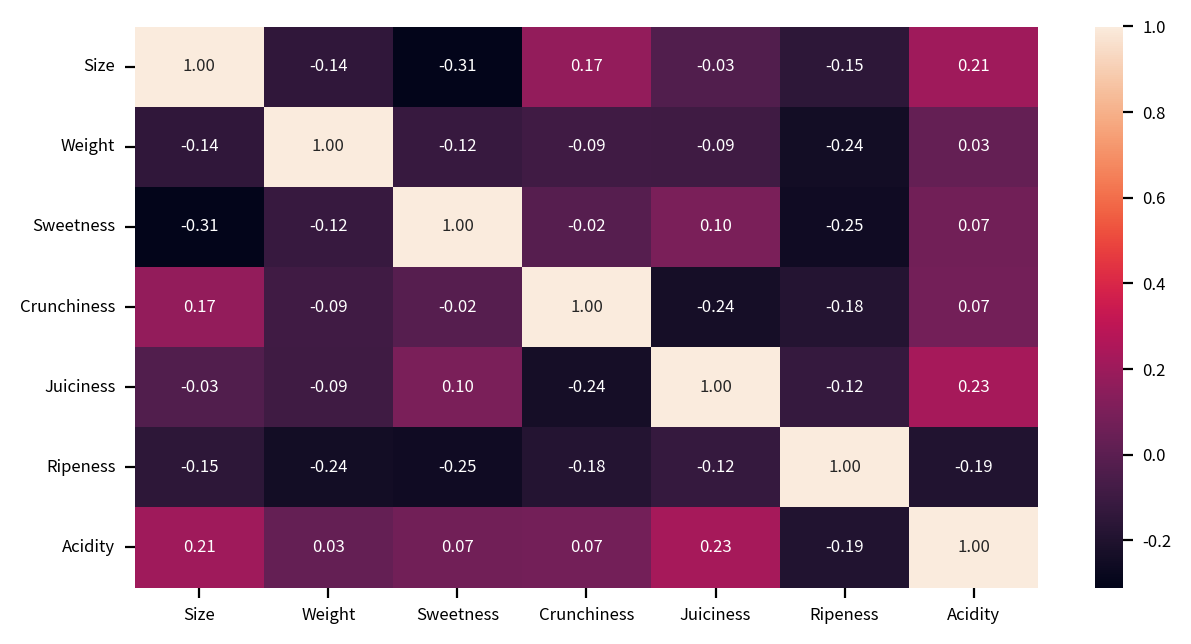

In [12]:
hs_plot.heatmap(corr)

#### 💡 인사이트

- 모든 상관계수가 |r| < 0.35 수준으로 낮아 다중공선성 위험이 거의 없다.
- 따라서 변수 제거는 성능보다 해석·단순성을 위한 선택에 가깝다.

## 6단계. 로지스틱 회귀 모델 적합 - “확률로 말하는 분류기”

1. 사용할 독립변수를 최종 선정하여 로지스틱 회귀 모델을 적합하자.
2. 모델을 성능을 향상시키기 위해 다양한 방법으로 모델을 구성해 보고 최적의 모형을 선정하자.
3. 회귀계수의 부호와 크기를 확인하자.
4. EDA에서 예상한 방향과 결과가 일치하는지 비교하자.

> 📌 **출제 의도**
> 모델 결과를 처음부터 해석 대상으로 보기보다,
> **EDA에서 세운 가설이 어떻게 반영되었는지 확인**하는 과정이다.

### 6-1. 최종 변수 선정

In [15]:
model_features = [
    "Size",
    "Sweetness",
    "Juiciness",
    "Ripeness",
    "Acidity",
    "Crunchiness",
    "Quality_bin",
]

df2 = df.filter(model_features)
df2.head()

,Size,Sweetness,Juiciness,Ripeness,Acidity,Crunchiness
0,-3.970049,5.346330,1.844900,0.329840,-0.491590,-1.012009
1,-1.195217,3.664059,0.853286,0.867530,-0.722809,1.588232
2,-0.292024,-1.738429,2.838636,-0.038033,2.621636,-0.342616
3,-0.657196,1.324874,3.637970,-3.413761,0.790723,-0.097875
4,1.364217,-0.384658,3.030874,-1.303849,0.501984,-0.553006


### 6-2. 기본 모형 적합

In [16]:
fit1 = hs_logit(df2, "Quality_bin")
cdf1, rdf1 = hs_logit_report(fit1, df2)
display(cdf1)
display(rdf1)

NameError: name 'hs_logit' is not defined

### 6-3. 유의하지 않은 변수를 제거함

In [ ]:
df3 = df2.drop("Crunchiness", axis=1)

fit2 = hs_logit(df3, "Quality_bin")
cdf2, rdf2 = hs_logit_report(fit2, df2)

display(cdf2)
display(rdf2)

#### 💡 인사이트

- EDA에서 Size/Sweetness/Juiciness가 good 쪽으로 높고 Ripeness/Acidity가 낮다는 패턴을 확인해 양수·음수를 각각 예상했고, 실제 계수는 Size=0.56, Sweetness=0.48, Juiciness=0.40, Ripeness=-0.21, Acidity=-0.27로 부호가 그대로 일치하며 크기도 당도≈크기>과즙>익음·산미 순으로 강약이 드러났다.
- Crunchiness는 기대했던 것처럼 계수가 거의 0이라 영향이 미미함을 재확인했다.

**영향이 미미한 변수를 제거하고 최종 모형으로 2번 모형을 선택**

## 7단계. 오즈비를 통한 해석 - “숫자를 다시 사람의 언어로”

1. 회귀계수를 오즈비로 변환하자.
2. 주요 변수 2~3개를 골라 해석 문장을 작성하자.
3. 이 해석이 EDA 결과와 어떻게 연결되는지 설명하자.

> 📌 **출제 의도**
> 이 단계의 목적은 계산이 아니라 **모델이 말하는 내용을 사람의 언어로 바꾸는 연습**이다.

In [ ]:
cdf, rdf, result_report, model_report, variable_reports, cm = hs_logit_report(
    fit2, df2, full=True
)

display(rdf)
display(result_report)
display(model_report)
display(variable_reports)
display(cm)

#### 💡 인사이트

- Size OR≈1.75: (표준화/원단위 변환 없이 주어진 스케일)에서 크기가 1단위 커지면 good 오즈가 약 75% 증가 → 크기가 품질에 가장 큰 플러스 요인.
- Sweetness OR≈1.61: 당도가 1단위 높아지면 good 오즈가 61% 증가 → EDA에서 본 달콤함 효과가 계수로도 재확인.
- Ripeness OR≈0.81: 익은 정도가 1단위 높아질수록 good 오즈가 약 19% 감소 → 과숙이 품질을 떨어뜨리는 흐름과 일치.
- Acidity OR≈0.76: 산미가 강할수록 good 가능성이 낮아지는 편으로, 맛 균형의 한계를 보여줌.

## 8단계. 시각화로 보는 모델 성능 - “모델은 어떤 판단을 하고 있을까?”

1. 혼동행렬을 시각화하자.
2. ROC Curve를 그리고 AUC를 계산하자.
3. ROC Curve의 모양을 말로 설명하자.

> 📌 **출제 의도**
> 성능 지표를 숫자로만 받아들이지 않고, **모델의 판단 특성을 이해하는 도구**로 활용하게 하기 위함이다.

### 8-1. 혼동행렬

In [ ]:
# 1) 그래프 초기화
width_px = 600  # 그래프 가로 크기
height_px = 400  # 그래프 세로 크기
rows = 1  # 그래프 행 수
cols = 1  # 그래프 열 수
figsize = (width_px / hs_dpi, height_px / hs_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=hs_dpi)

# 2) heatmap 그리기
sb.heatmap(
    data=cm,
    annot=True,
    fmt="0.1f",
    linewidth=0.5,
    cmap="PuOr",
    xticklabels=["예측:bad", "예측:good"],
    yticklabels=["실제:bad", "실제:good"],
)

# 3) 그래프 꾸미기
ax.set_title("혼동행렬 (threshold=0.5)")
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()  # x축의 변수 이름을 상단으로 이동

# 4) 출력
plt.tight_layout()  # 여백 제거
plt.show()  # 그래프 화면 출력
plt.close()  # 그래프 작업 종료

### 8-3. ROC Curve

In [ ]:
pred_prob = fit2.predict(fit2.model.exog)

fpr, tpr, _ = roc_curve(fit2.model.endog, pred_prob)
auc = roc_auc_score(fit2.model.endog, pred_prob)
plt.figure(figsize=(4, 4), dpi=hs_dpi)
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="무작위")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

rdf

#### 💡 인사이트

- 혼동행렬: TN=1439, FP=557, FN=511, TP=1493으로 good 재현율(0.745)과 정밀도(0.728)가 비슷한 균형형 모델.
- ROC 곡선이 좌상단으로 볼록하며 AUC=0.81 → 무작위 분류(0.5) 대비 약 31%p 높은 판별력으로 임계값을 어떻게 잡아도 일관된 이득을 준다.
- Accuracy=0.73 수준으로 클래스 균형을 감안하면 무작위(0.5) 대비 개선 효과가 뚜렷하다.

## 9단계. 같은 조건, 다른 판단 - “모델은 어디서 갈림길을 만들었을까?”

1. 가상의 사과 두 개를 설정하자.
2. 예측 확률이 달라진 이유를 분석하자.
3. EDA → 회귀계수 → 확률의 흐름으로 설명하자.

> 📌 **출제 의도**
> 이 단계는 분석의 마무리 단계로, **모델의 판단을 대신 설명할 수 있는지**를 확인하기 위한 문제이다.

In [ ]:
# 10단계 풀이: 가상 사례 비교
scenario = DataFrame(
    {
        "Size": [1.0, -1.5],
        "Sweetness": [1.2, -1.0],
        "Juiciness": [1.5, -1.2],
        "Ripeness": [-0.5, 1.2],
        "Acidity": [0.1, 0.5],
    },
    index=["달고촉촉한_사과", "덜달고무른_사과"],
)
scenario_const = sm.add_constant(scenario)
scenario["pred_prob"] = fit2.predict(scenario_const)
display(scenario)

#### 💡 인사이트

- `달고촉촉한_사과`는 Size·Sweetness·Juiciness가 높고 Ripeness가 낮아 good 확률 0.90 → EDA에서 중요하다고 본 양의 요인이 모두 높다.
- `덜달고무른_사과`는 당도·과즙이 낮고 Ripeness가 높아 과숙에 가깝다 보니 good 확률 0.15 → 음의 요인이 겹쳐 odds가 크게 줄었다.
- 흐름: EDA에서 확인한 (크고 달고 촉촉하면 good, 과숙하면 bad) 패턴이 계수 부호와 오즈비로 확인되었고, 그 조합이 예측 확률 차이를 만들어 냄. 계수(가중치)×입력값 합이 첫 사례에서는 크게 양수여서 로짓이 +, 두 번째는 음수여서 로짓이 -로 가며 확률이 갈린다.